In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image, ImageDraw, ImageFont

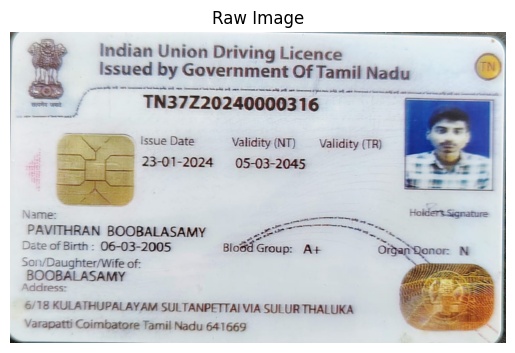

In [19]:
# Load the image
image_path = "./Driving_Licence_Front.jpg"
image = cv2.imread(image_path)

# Display the raw image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Raw Image')
plt.show()

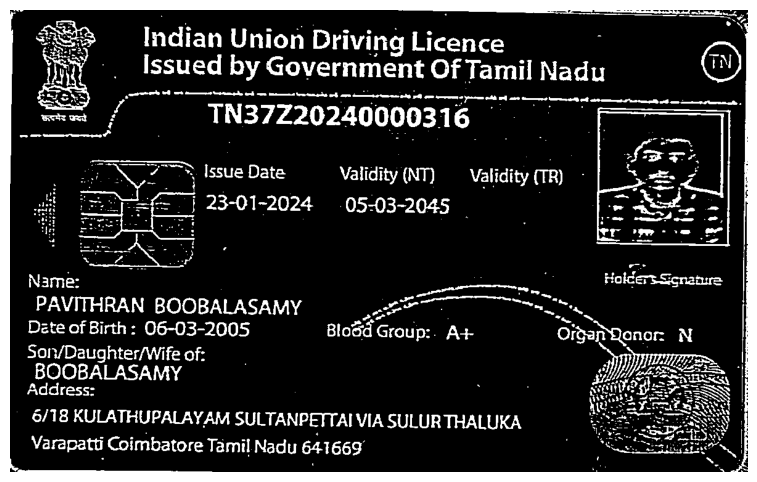

In [20]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# Adaptive thresholding
binary = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 6
)

# Morphological operations to refine text
kernel = np.ones((1, 1), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
binary = cv2.dilate(binary, kernel, iterations=1)

# Normalize intensity for better contrast
binary = cv2.equalizeHist(binary)

# Further sharpen text
sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
binary = cv2.filter2D(binary, -1, sharpen_kernel)

# Display the final optimized image
plt.figure(figsize=(10, 6))
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

In [21]:
# Initialize PaddleOCR (CPU mode)
ocr = PaddleOCR(use_angle_cls=True, lang="en")  # Change "en" if needed

# Run OCR
result = ocr.ocr(binary, cls=True)

# Print extracted text with confidence scores
print("Extracted Text:")
for line in result:
    for word_info in line:
        text = word_info[1][0]  # Extract detected text
        confidence = word_info[1][1]  # Confidence score
        print(f"Detected Text: {text}, Confidence: {confidence}")

[2025/02/17 22:53:37] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\LogaSanjeev/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\LogaSanjeev/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', re

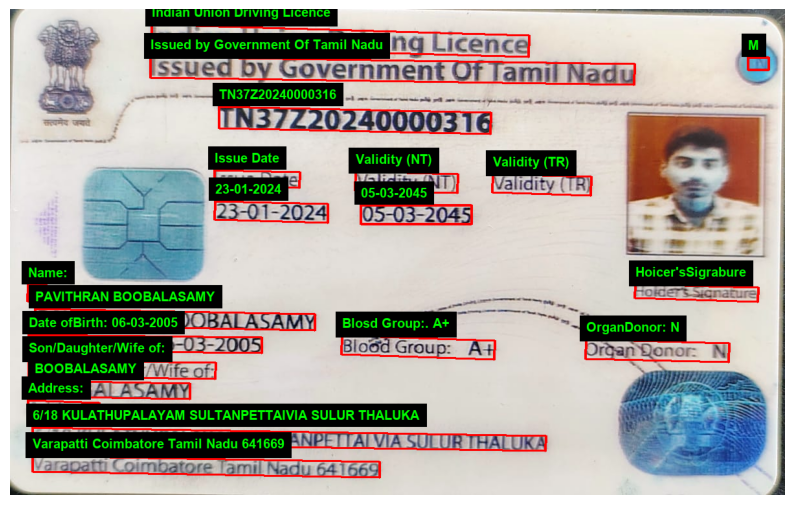

In [22]:
# Convert to PIL Image for easier text rendering
image_pil = Image.fromarray(image)
draw = ImageDraw.Draw(image_pil)

# Choose a bold font (Ensure you have a valid font file)
font_path = r"C:\Windows\Fonts\arialbd.ttf"  # Change to a bold font
try:
    font = ImageFont.truetype(font_path, 20)  # Increase font size
except IOError:
    print("Font file not found, using default font.")
    font = ImageFont.load_default()

# Draw bounding boxes and text with enhancements
for line in result:
    for word_info in line:
        box = word_info[0]  # Bounding box points
        text = word_info[1][0]  # Extracted text

        # Convert box points to a format suitable for PIL
        box = [tuple(point) for point in box]

        # Draw a thicker bounding box
        draw.line([box[0], box[1], box[2], box[3], box[0]], fill="red", width=4)

        # Define text position
        text_x, text_y = int(box[0][0]), int(box[0][1] - 30)
        text_padding = 10  # Padding around text

        # Get text bounding box (new method)
        bbox = draw.textbbox((text_x, text_y), text, font=font)
        rect_x1, rect_y1, rect_x2, rect_y2 = (
            bbox[0] - text_padding, bbox[1] - text_padding,
            bbox[2] + text_padding, bbox[3] + text_padding
        )

        # Draw a solid black background rectangle behind the text
        draw.rectangle([rect_x1, rect_y1, rect_x2, rect_y2], fill="black")

        # Draw the text in vibrant green for high contrast
        draw.text((text_x, text_y), text, fill="lime", font=font)

# Convert back to NumPy array
image_np = np.array(image_pil)

# Display the image with bounding boxes and text inline
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis("off")  # Hide axis
plt.show()